In [69]:
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import cftime
import cmocean
import datetime
from matplotlib.colors import LightSource
import matplotlib.patheffects as path_effects
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cartopyticker
import rasterio
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
coast = cfeature.GSHHSFeature(scale="f")
plt.rcParams.update({'font.size': 18})

In [2]:
datadir = "../../data/DINEOF/"
figdir = "../../figures/DINEOF/"
if not os.path.isdir(figdir):
    os.makedirs(figdir)
datafile = os.path.join(datadir, "sst_L3_Gulf_Lion_a.nc")
outputfile = os.path.join(datadir, "sst_L4_dineof_Gulf_Lion_a.nc")

## Read data
### L3 data + DINEOF reconstruction

In [3]:
with netCDF4.Dataset(datafile, "r") as nc:
    lonL3 = nc.variables["lon"][:]
    latL3 = nc.variables["lat"][:]
    SSTL3 = nc.variables["SST"][:]
    mask = nc.variables["mask"][:]
    times = nc.variables["time"][:]
    timeunits = "days since 2017-1-1 0:0:0" 
    dates = netCDF4.num2date(times, timeunits, only_use_cftime_datetimes=False)
    
with netCDF4.Dataset(outputfile, "r") as nc:
    SSTL4 = nc.variables["sst_filled"][:]

Find the index for the first date (1 August)

In [5]:
firsdate = np.where(dates == datetime.datetime(2019, 8, 1))[0][0]
firsdate

91

## Make plot
### Define domain and projection

In [6]:
domain = [0., 12., 40., 45.]
theproj = ccrs.Mercator(central_longitude=0.5 * (domain[0] + domain[1]), 
                        min_latitude=domain[2], max_latitude=domain[3], 
                        latitude_true_scale=0.5 * (domain[2] + domain[3]))
datacrs = ccrs.PlateCarree()

In [7]:
cmap = plt.cm.RdYlBu_r
SSTmin = 17.
SSTmax = 30.

In [34]:
fig = plt.figure(figsize=(12, 10))

 
ax1 = plt.subplot(211, projection=theproj)
ax1.set_extent(domain)

# Original
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='.75', alpha=0.95, linestyle='--', zorder=5)
gl.right_labels = False
gl.bottom_labels = False
gl.top_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(coast, color=".85", zorder=5)
ax1.add_feature(coast, linewidth=.25, zorder=6)

pcm1 = ax1.pcolormesh(lonL3, latL3, SSTL3[10,:,:], transform=datacrs, cmap=cmap, vmin=SSTmin, vmax=SSTmax)

# Reconstructed
ax2 = plt.subplot(212, projection=theproj)
ax2.set_extent(domain)

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='.75', alpha=0.95, linestyle='--', zorder=5)
gl.bottom_labels = True
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax2.add_feature(coast, color=".85", zorder=5)
ax2.add_feature(coast, linewidth=.25, zorder=6)

pcm2 = ax2.pcolormesh(lonL3, latL3, SSTL4[10,:,:], transform=datacrs, cmap=cmap, vmin=SSTmin, vmax=SSTmax)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.8, 0.15, 0.035, 0.7])
cb = plt.colorbar(pcm2, cax=cbar_ax, orientation="vertical", extend="both")
cb.set_label("°C", rotation=0, ha="left")

# Loop on time
for tt in range(firsdate, firsdate + 30):
    
    pcm1.remove()
    pcm2.remove()
    pcm1 = ax1.pcolormesh(lonL3, latL3, SSTL3[tt,:,:], transform=datacrs, cmap=cmap, vmin=SSTmin, vmax=SSTmax)
    pcm2 = ax2.pcolormesh(lonL3, latL3, SSTL4[tt,:,:], transform=datacrs, cmap=cmap, vmin=SSTmin, vmax=SSTmax)
    datestring = datetime.datetime.strftime(dates[tt], "%Y-%m-%d")
    datestring2 = datetime.datetime.strftime(dates[tt], "%Y%m%d")

    ax1.set_title(datestring)
   
    plt.savefig(os.path.join(figdir, f"dineof_{datestring2}.jpg"), dpi=300, bbox_inches="tight")

In [62]:
SSTall = SSTL4[firsdate:firsdate+31,:,:]
SSTall.max()

31.074626959004448

### DINEOF analysis only

In [66]:
SSTmin, SSTmax = 20., 28.
fig = plt.figure(figsize=(12, 10))

 
ax1 = plt.subplot(111, projection=theproj)
ax1.set_extent(domain)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='.75', alpha=0.95, linestyle='--', zorder=5)
gl.bottom_labels = True
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(coast, color=".85", zorder=5)
ax1.add_feature(coast, linewidth=.25, zorder=6)

pcm2 = ax1.pcolormesh(lonL3, latL3, SSTL4[firsdate,:,:], transform=datacrs, 
                      cmap=cmap, vmin=SSTmin, vmax=SSTmax)

cb = plt.colorbar(pcm2, orientation="vertical", extend="both", shrink=.6)
cb.set_label("°C", rotation=0, ha="left")

# Loop on time
for tt in range(firsdate, firsdate + 31):
    
    pcm2.remove()
    pcm2 = ax1.pcolormesh(lonL3, latL3, SSTL4[tt,:,:], transform=datacrs, cmap=cmap, vmin=SSTmin, vmax=SSTmax)
    datestring = datetime.datetime.strftime(dates[tt], "%Y-%m-%d")
    datestring2 = datetime.datetime.strftime(dates[tt], "%Y%m%d")

    ax1.set_title(datestring)
   
    plt.savefig(os.path.join(figdir, f"dineof_analysis_{datestring2}.jpg"), dpi=300, bbox_inches="tight")
    
plt.close()

### Difference between 2 analysis

In [68]:
date1 = datetime.datetime(2019, 8, 10)
date2 = datetime.datetime(2019, 8, 17) 

dateindex1 = np.where(dates == date1)[0][0]
dateindex2 = np.where(dates == date2)[0][0]

SSTdiff = SSTL4[dateindex2,:,:] - SSTL4[dateindex1,:,:] 

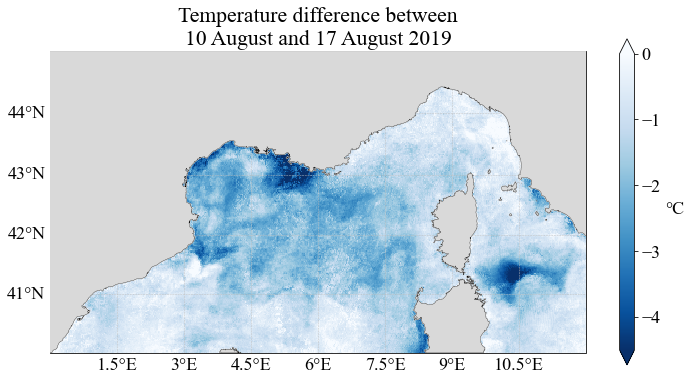

In [80]:
SSTmin, SSTmax = 20., 28.
fig = plt.figure(figsize=(12, 10))

 
ax1 = plt.subplot(111, projection=theproj)
ax1.set_extent(domain)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='.75', alpha=0.95, linestyle='--', zorder=5)
gl.bottom_labels = True
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(coast, color=".85", zorder=5)
ax1.add_feature(coast, linewidth=.25, zorder=6)

pcm2 = ax1.pcolormesh(lonL3, latL3, SSTdiff, transform=datacrs, 
                      cmap=plt.cm.Blues_r,
                      vmin=-4.5, vmax=0)

cb = plt.colorbar(pcm2, orientation="vertical", extend="both", shrink=.6)
cb.set_ticks([0, -1, -2, -3, -4])
cb.set_label("°C", rotation=0, ha="left")

dstring1 = datetime.datetime.strftime(date1, "%d %B")
dstring2 = datetime.datetime.strftime(date2, "%d %B %Y")


ax1.set_title(f"Temperature difference between\n{dstring1} and {dstring2}")
   
plt.savefig(os.path.join(figdir, f"dineof_temperature_diff"), dpi=300, bbox_inches="tight")
plt.show() 
plt.close()

### Plot the time series near the station

In [8]:
latsta, lonsta = 42.067, 4.671

lonindex = np.argmin(abs(lonL3 - lonsta))
latindex = np.argmin(abs(latL3 - latsta))

lonL3[lonindex], latL3[latindex]

(4.67, 42.07)

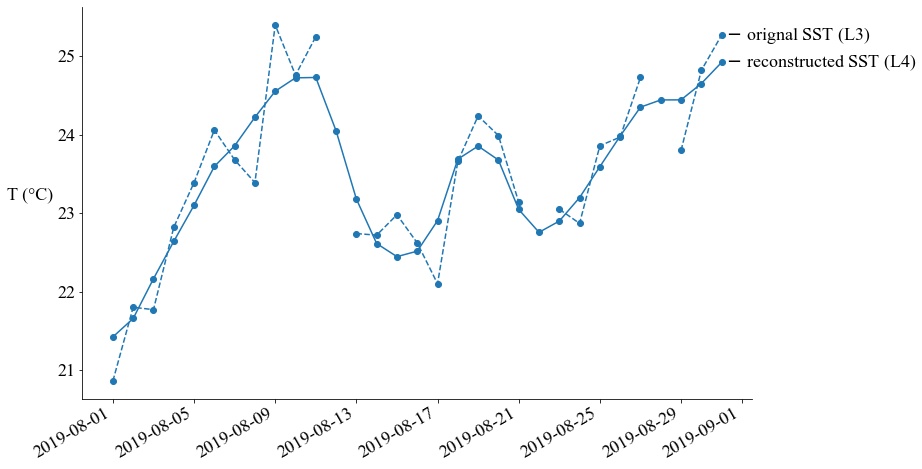

In [24]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
line1 = ax.plot(dates[firsdate:firsdate+31], SSTL3[firsdate:firsdate+31,latindex, lonindex], "o--")
thecolor = line1[0].get_color()

ax.plot(dates[firsdate:firsdate+31], SSTL4[firsdate:firsdate+31,latindex, lonindex], "o-", color=thecolor)
ax.set_ylabel("T (°C)", rotation=0, ha="right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add text labels
ax.text(dates[firsdate+30], SSTL3[firsdate+30,latindex, lonindex], " $-$ orignal SST (L3)", 
        ha="left", va="center")
ax.text(dates[firsdate+30], SSTL4[firsdate+30,latindex, lonindex], " $-$ reconstructed SST (L4)", 
        ha="left", va="center")



#plt.title(f"Temperature at platform {wmocode}")
# plt.grid()
fig.autofmt_xdate()
# plt.savefig(os.path.join(figdir, "dineof_timeseries"), dpi=300, bbox_inches="tight")
plt.show()

### Average around the mooring

<ipython-input-56-4ba7e06785b3>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(dates[firsdate:firsdate+31], SSTL4mean, "ro-", color=thecolor)


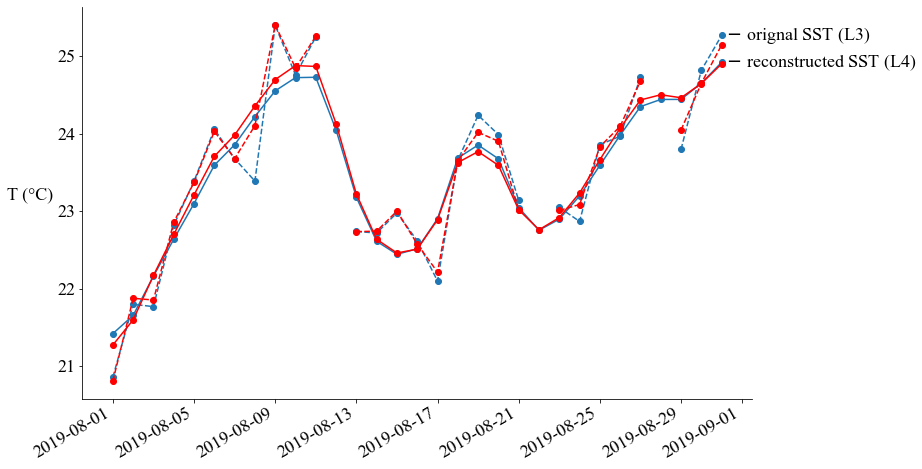

In [56]:
SSTL3mean = np.nanmean(np.nanmean(SSTL3[firsdate:firsdate+31, latindex-1:latindex+2, lonindex-1:lonindex+2], axis=1), axis=1)
SSTL4mean = np.nanmean(np.nanmean(SSTL4[firsdate:firsdate+31, latindex-1:latindex+2, lonindex-1:lonindex+2], axis=1), axis=1)

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
line1 = ax.plot(dates[firsdate:firsdate+31], SSTL3[firsdate:firsdate+31,latindex, lonindex], "o--")
thecolor = line1[0].get_color()

ax.plot(dates[firsdate:firsdate+31], SSTL4[firsdate:firsdate+31,latindex, lonindex], "o-", color=thecolor)

line1 = ax.plot(dates[firsdate:firsdate+31], SSTL3mean, "ro--")
thecolor = line1[0].get_color()

ax.plot(dates[firsdate:firsdate+31], SSTL4mean, "ro-", color=thecolor)


ax.set_ylabel("T (°C)", rotation=0, ha="right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add text labels
ax.text(dates[firsdate+30], SSTL3[firsdate+30,latindex, lonindex], " $-$ orignal SST (L3)", 
        ha="left", va="center")
ax.text(dates[firsdate+30], SSTL4[firsdate+30,latindex, lonindex], " $-$ reconstructed SST (L4)", 
        ha="left", va="center")



#plt.title(f"Temperature at platform {wmocode}")
# plt.grid()
fig.autofmt_xdate()
# plt.savefig(os.path.join(figdir, "dineof_timeseries"), dpi=300, bbox_inches="tight")
plt.show()

#### Add the mooring platform

In [50]:
mooringfile = '../../data/CMEMS/GL_TS_MO_6100002.nc'

In [27]:
def get_time_temp(datafile):
    with netCDF4.Dataset(datafile) as nc:
        T = nc.get_variables_by_attributes(standard_name="sea_water_temperature")[0][:,1]
        timevar = nc.get_variables_by_attributes(standard_name="time")[0]
        depth = nc.get_variables_by_attributes(standard_name="depth")[0][:]
        timeunit = timevar.units
        dates = netCDF4.num2date(timevar[:], timeunit, only_use_cftime_datetimes=False)
        wmocode = nc.wmo_platform_code
    return dates, T, wmocode, depth

In [29]:
dates_mooring, T_mooring, wmocode, depth_mooring = get_time_temp(mooringfile)
# Compute and plot local max
gooddates = np.where( (dates_mooring >= datetime.datetime(2019, 8, 1)) & 
                        (dates_mooring <= datetime.datetime(2019, 8, 31)))[0]

In [38]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
line1 = ax.plot(dates[firsdate:firsdate+31], SSTL3[firsdate:firsdate+31,latindex, lonindex], "o-.", color=".15")
thecolor = line1[0].get_color()

ax.plot(dates[firsdate:firsdate+31], SSTL4[firsdate:firsdate+31,latindex, lonindex], "s-", color=thecolor)
line2 = ax.plot(dates_mooring[gooddates], T_mooring[gooddates], "-")
thecolor2 = line2[0].get_color()

ax.set_ylabel("T (°C)", rotation=0, ha="right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add text labels
ax.text(dates[firsdate+30], SSTL3[firsdate+30,latindex, lonindex], " $-$ original SST (L3)", 
        ha="left", va="center", color=thecolor)
ax.text(dates[firsdate+30], SSTL4[firsdate+30,latindex, lonindex], " $-$ reconstructed SST (L4)", 
        ha="left", va="center", color=thecolor)
ax.text(dates_mooring[gooddates][-1], T_mooring[gooddates][-1], " $-$ mooring", 
        ha="left", va="center", color=thecolor2)


#plt.title(f"Temperature at platform {wmocode}")
# plt.grid()
fig.autofmt_xdate()
plt.savefig(os.path.join(figdir, "dineof_timeseries_mooring"), dpi=300, bbox_inches="tight")
plt.show()